<h1 style="text-align: center;">NASA Jet Engine Degradation(CMAPSS)</h1>


In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import optuna
import matplotlib.pyplot as plt

C:\Users\sanik\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load all datasets

In [2]:
col_names = ['engine_id', 'cycle', 'Op_Setting_1', 'Op_Setting_2', 'Op_Setting_3'] + \
            [f'Sensor_{i}' for i in range(1, 22)]

train = pd.read_csv(r"C:\Users\sanik\Downloads\nasa\train_FD001.txt", sep=r"\s+", header=None)
train.columns = col_names
train.head()


,engine_id,cycle,Op_Setting_1,Op_Setting_2,Op_Setting_3,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5,...,Sensor_12,Sensor_13,Sensor_14,Sensor_15,Sensor_16,Sensor_17,Sensor_18,Sensor_19,Sensor_20,Sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [3]:

test_data = pd.read_csv(r"C:\Users\sanik\Downloads\nasa\test_FD001.txt", sep=r"\s+", header=None)
test_data.columns = col_names
rul_df = pd.read_csv(r"C:\Users\sanik\Downloads\nasa\RUL_FD001.txt", sep=r"\s+", header=None)
rul_df.columns = ["RUL"]


### Calculate RUL for training data

In [4]:
rul_per_engine = train.groupby('engine_id')['cycle'].max().reset_index()
rul_per_engine.columns = ['engine_id', 'Max_Cycle']

train_data = train.merge(rul_per_engine, on='engine_id')
train_data['RUL'] = train_data['Max_Cycle'] - train_data['cycle']
train_data.drop(columns=['Max_Cycle'], inplace=True)

train_data.head(10)


,engine_id,cycle,Op_Setting_1,Op_Setting_2,Op_Setting_3,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5,...,Sensor_13,Sensor_14,Sensor_15,Sensor_16,Sensor_17,Sensor_18,Sensor_19,Sensor_20,Sensor_21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187
5,1,6,-0.0043,-0.0001,100.0,518.67,642.10,1584.47,1398.37,14.62,...,2388.03,8132.85,8.4108,0.03,391,2388,100.0,38.98,23.3669,186
6,1,7,0.0010,0.0001,100.0,518.67,642.48,1592.32,1397.77,14.62,...,2388.03,8132.32,8.3974,0.03,392,2388,100.0,39.10,23.3774,185
7,1,8,-0.0034,0.0003,100.0,518.67,642.56,1582.96,1400.97,14.62,...,2388.03,8131.07,8.4076,0.03,391,2388,100.0,38.97,23.3106,184
8,1,9,0.0008,0.0001,100.0,518.67,642.12,1590.98,1394.80,14.62,...,2388.05,8125.69,8.3728,0.03,392,2388,100.0,39.05,23.4066,183
9,1,10,-0.0033,0.0001,100.0,518.67,641.71,1591.24,1400.46,14.62,...,2388.06,8129.38,8.4286,0.03,393,2388,100.0,38.95,23.4694,182


In [5]:
test_data.head()

,engine_id,cycle,Op_Setting_1,Op_Setting_2,Op_Setting_3,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5,...,Sensor_12,Sensor_13,Sensor_14,Sensor_15,Sensor_16,Sensor_17,Sensor_18,Sensor_19,Sensor_20,Sensor_21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


### Preprocess data

In [6]:


features = ['Op_Setting_1', 'Op_Setting_2', 'Op_Setting_3'] + [f'Sensor_{i}' for i in range(1, 22)]

scaler = MinMaxScaler()

# Fit scaler on train features only
train_data[features] = scaler.fit_transform(train_data[features])

# Apply same scaler to test set features
test_data[features] = scaler.transform(test_data[features])


In [7]:
import joblib
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

In [8]:

SEQ_LEN = 30
FEATURES = ['Op_Setting_1', 'Op_Setting_2', 'Op_Setting_3'] + [f'Sensor_{i}' for i in range(1, 22)]
MAX_EPOCHS = 50
N_TRIALS = 5


### Prepare sequences

In [13]:

def create_sequences(df, seq_len):
    X, y = [], []
    for _, group in df.groupby('engine_id'):
        group = group.sort_values('cycle')
        for i in range(len(group) - seq_len):
            seq_x = group[FEATURES].iloc[i:i+seq_len].values
            seq_y = group['RUL'].iloc[i+seq_len]
            X.append(seq_x)
            y.append(seq_y)
    return np.array(X), np.array(y)

### Prepare test sequences

In [14]:

def create_last_seq_per_engine(df, seq_len, rul_df):
    X, y = [], []
    engines = sorted(df['engine_id'].unique())  # keep consistent order

    for idx, engine_id in enumerate(engines):
        group = df[df['engine_id'] == engine_id].sort_values('cycle')
        if len(group) >= seq_len:
            seq_x = group[FEATURES].iloc[-seq_len:].values
            seq_y = rul_df.iloc[idx, 0]  # take RUL from same position
            X.append(seq_x)
            y.append(seq_y)

    return np.array(X), np.array(y)



In [15]:
def create_last_seq_per_engine_tuning(df, seq_len):
    X, engine_ids = [], []
    for engine_id, group in df.groupby('engine_id'):
        group = group.sort_values('cycle')
        if len(group) >= seq_len:
            seq_x = group[FEATURES].iloc[-seq_len:].values
            X.append(seq_x)
            engine_ids.append(engine_id)
    return np.array(X), engine_ids

<h2 style="text-align: center;">Using LSTM</h2>

In [ ]:

model = Sequential([
    LSTM(100, input_shape=(SEQ_LEN, len(FEATURES))),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=64,
    callbacks=[early_stop],
    verbose=2
)


C:\Users\sanik\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
274/274 - 22s - 79ms/step - loss: 8684.0010
Epoch 2/30


C:\Users\sanik\anaconda3\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


274/274 - 17s - 63ms/step - loss: 5787.1763
Epoch 3/30
274/274 - 18s - 67ms/step - loss: 4530.9385
Epoch 4/30
274/274 - 18s - 67ms/step - loss: 4026.0503
Epoch 5/30
274/274 - 18s - 67ms/step - loss: 3860.6230
Epoch 6/30
274/274 - 20s - 73ms/step - loss: 3707.6833
Epoch 7/30
274/274 - 17s - 63ms/step - loss: 2885.5198
Epoch 8/30
274/274 - 19s - 70ms/step - loss: 2163.6182
Epoch 9/30
274/274 - 22s - 80ms/step - loss: 1784.5867
Epoch 10/30
274/274 - 20s - 72ms/step - loss: 1518.4530
Epoch 11/30
274/274 - 18s - 66ms/step - loss: 1375.5309
Epoch 12/30
274/274 - 20s - 74ms/step - loss: 1277.8763
Epoch 13/30
274/274 - 19s - 70ms/step - loss: 1180.0454
Epoch 14/30
274/274 - 20s - 73ms/step - loss: 1141.2311
Epoch 15/30
274/274 - 20s - 72ms/step - loss: 1123.2898
Epoch 16/30
274/274 - 19s - 68ms/step - loss: 1068.9038
Epoch 17/30
274/274 - 17s - 63ms/step - loss: 1073.7915
Epoch 18/30
274/274 - 20s - 74ms/step - loss: 1047.9745
Epoch 19/30
274/274 - 21s - 77ms/step - loss: 1009.3106
Epoch 20/30

### EVALUATE MODEL

In [ ]:

X_test, y_test = create_last_seq_per_engine(test_data, SEQ_LEN, rul_df)
y_pred = model.predict(X_test).flatten()

rmse=np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = 1 - (np.sum((y_test - y_pred) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2))

print(f"\nFinal Test RMSE: {rmse:.2f}")
print(f"Final Test MAE: {mae:.2f}")
print(f"Final Test R²: {r2:.2f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step

Final Test RMSE: 21.18
Final Test MAE: 14.93
Final Test R²: 0.74


### Plot predicted vs actual RUL for test engines

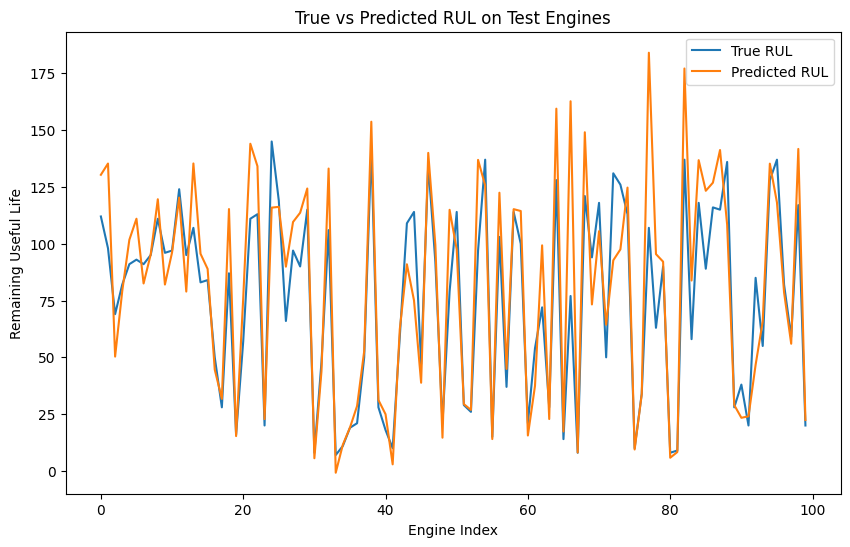

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(y_test, label='True RUL')
plt.plot(y_pred, label='Predicted RUL')
plt.xlabel('Engine Index')
plt.ylabel('Remaining Useful Life')
plt.title('True vs Predicted RUL on Test Engines')
plt.legend()
plt.show()


## **Using WALK-FORWARD + OPTUNA for LSTM**

In [23]:
def build_lstm(trial, input_shape):
    units = trial.suggest_int("units", 32, 128, step=32)
    dense_units = trial.suggest_int("dense_units", 32, 128, step=32)
    dropout_rate = trial.suggest_float("dropout", 0.0, 0.3, step=0.1)
    lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)

    model = Sequential([
        LSTM(units, input_shape=input_shape, dropout=dropout_rate),
        Dense(dense_units, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(lr),
                  loss='mse')
    return model

In [24]:

sampled_engine_ids = [2, 20, 30, 42, 78]
results_list = []

for engine_id in sampled_engine_ids:
    val_group = train_data[train_data['engine_id'] == engine_id]
    train_subset = train_data[train_data['engine_id'] != engine_id]

    X_train, y_train = create_sequences(train_subset, SEQ_LEN)
    X_val, y_val = create_last_seq_per_engine_tuning(val_group, SEQ_LEN)
    if X_val.shape[0] == 0:
        continue

    input_shape = (X_train.shape[1], X_train.shape[2])

    def objective(trial):
        model = build_lstm(trial, input_shape)
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        model.fit(X_train, y_train, validation_split=0.2,
                  epochs=MAX_EPOCHS, batch_size=64,
                  verbose=0, callbacks=[early_stop])
        val_pred = model.predict(X_val, verbose=0).flatten()
        rmse = np.sqrt(mean_squared_error(y_val, val_pred))
        return rmse

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=N_TRIALS)

    best_params = study.best_params
    best_rmse = study.best_value

    results_list.append({"engine_id": engine_id, "rmse": best_rmse, "params": best_params})
    print(f"Engine {engine_id} → RMSE: {best_rmse:.4f} | Best Params: {best_params}")



[I 2025-08-10 07:11:09,810] A new study created in memory with name: no-name-b55ac251-2544-434a-a220-5a926a85916f
/tmp/ipython-input-3950433730.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-08-10 07:11:31,583] Trial 0 finished with value: 10.001352218755885 and parameters: {'units': 128, 'dense_units': 128, 'dropout': 0.3, 'lr': 0.0013742551016167194}. Best is trial 0 with value: 10.001352218755885.
/tmp/ipython-input-3950433730.py:5: FutureWarning: suggest_loguniform has been deprecate

Engine 2 → RMSE: 0.6552 | Best Params: {'units': 128, 'dense_units': 64, 'dropout': 0.0, 'lr': 0.0029245797331173286}


[I 2025-08-10 07:13:07,032] A new study created in memory with name: no-name-b413a86e-b526-400c-aae2-dbe963d270c6
/tmp/ipython-input-3950433730.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-08-10 07:13:24,810] Trial 0 finished with value: 7.903851412886152 and parameters: {'units': 32, 'dense_units': 32, 'dropout': 0.2, 'lr': 0.0015781877279143319}. Best is trial 0 with value: 7.903851412886152.
/tmp/ipython-input-3950433730.py:5: FutureWarning: suggest_loguniform has been deprecated in

Engine 20 → RMSE: 0.5869 | Best Params: {'units': 32, 'dense_units': 128, 'dropout': 0.2, 'lr': 0.0012686460415723432}


[I 2025-08-10 07:14:56,134] A new study created in memory with name: no-name-d040a8b4-50db-43bc-a8f5-cfeaff357a2b
/tmp/ipython-input-3950433730.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-08-10 07:15:13,416] Trial 0 finished with value: 22.703196242575764 and parameters: {'units': 128, 'dense_units': 64, 'dropout': 0.2, 'lr': 0.0007205908333527693}. Best is trial 0 with value: 22.703196242575764.
/tmp/ipython-input-3950433730.py:5: FutureWarning: suggest_loguniform has been deprecated

Engine 30 → RMSE: 22.7032 | Best Params: {'units': 128, 'dense_units': 64, 'dropout': 0.2, 'lr': 0.0007205908333527693}


[I 2025-08-10 07:17:10,218] A new study created in memory with name: no-name-a6665144-3178-4cb5-991c-4f7c89700935
/tmp/ipython-input-3950433730.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-08-10 07:17:25,953] Trial 0 finished with value: 7.918796640934689 and parameters: {'units': 128, 'dense_units': 128, 'dropout': 0.2, 'lr': 0.005221524283500018}. Best is trial 0 with value: 7.918796640934689.
/tmp/ipython-input-3950433730.py:5: FutureWarning: suggest_loguniform has been deprecated i

Engine 42 → RMSE: 7.9188 | Best Params: {'units': 128, 'dense_units': 128, 'dropout': 0.2, 'lr': 0.005221524283500018}


[I 2025-08-10 07:19:50,331] A new study created in memory with name: no-name-c7279cec-eaf5-4d4a-84b6-e18571b05358
/tmp/ipython-input-3950433730.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-08-10 07:20:08,522] Trial 0 finished with value: 70.9914614418963 and parameters: {'units': 96, 'dense_units': 128, 'dropout': 0.1, 'lr': 0.00076964312999098}. Best is trial 0 with value: 70.9914614418963.
/tmp/ipython-input-3950433730.py:5: FutureWarning: suggest_loguniform has been deprecated in v3

Engine 78 → RMSE: 63.0361 | Best Params: {'units': 32, 'dense_units': 128, 'dropout': 0.1, 'lr': 0.003742629111931492}


### BEST PARAMS

In [25]:

results_df = pd.DataFrame(results_list)
best_row = results_df.loc[results_df["rmse"].idxmin()]
global_best_params = best_row["params"]

print("\nBest engine for tuning:", best_row["engine_id"])
print("Lowest RMSE:", best_row["rmse"])
print("Global Best Hyperparameters:", global_best_params)




Best engine for tuning: 20
Lowest RMSE: 0.5868530241697949
Global Best Hyperparameters: {'units': 32, 'dense_units': 128, 'dropout': 0.2, 'lr': 0.0012686460415723432}


### TRAIN TUNED LSTM MODEL

In [27]:

X_train_full, y_train_full = create_sequences(train_data, SEQ_LEN)
input_shape = (X_train_full.shape[1], X_train_full.shape[2])

final_model = Sequential([
    LSTM(int(global_best_params["units"]), input_shape=input_shape, dropout=float(global_best_params["dropout"])),
    Dense(int(global_best_params["dense_units"]), activation='relu'),
    Dense(1)
])
final_model.compile(optimizer=tf.keras.optimizers.Adam(float(global_best_params["lr"])),
                    loss='mse')

final_model.fit(X_train_full, y_train_full, epochs=MAX_EPOCHS, batch_size=64,
                callbacks=[EarlyStopping(monitor='loss', patience=5)], verbose=1)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 7891.8579
Epoch 2/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3730.9011
Epoch 3/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1956.9128
Epoch 4/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1559.6450
Epoch 5/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1397.3752
Epoch 6/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1311.2119
Epoch 7/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1261.1238
Epoch 8/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1285.3516
Epoch 9/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1220.4510
Epoch 10/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1200.7142
Epoch 11/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1164.1713
Epoch 12/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1121.6090
Epoch 13/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1171.0188
Epoch 14/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1148.0469
Epoch 15/50
276/276 ━━━━━━

### EVALUATE MODEL

In [28]:

X_test, y_test = create_last_seq_per_engine(test_data, SEQ_LEN, rul_df)
y_pred = final_model.predict(X_test).flatten()

rmse=np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = 1 - (np.sum((y_test - y_pred) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2))

print(f"\nFinal Test RMSE: {rmse:.2f}")
print(f"Final Test MAE: {mae:.2f}")
print(f"Final Test R²: {r2:.2f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

Final Test RMSE: 19.02
Final Test MAE: 13.68
Final Test R²: 0.79


### Plot predicted vs actual RUL for test engines

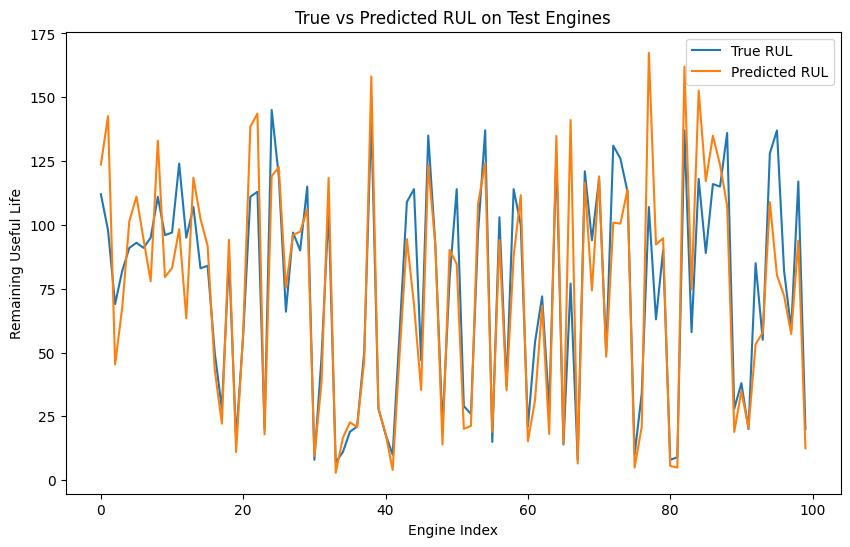

In [29]:
plt.figure(figsize=(10,6))
plt.plot(y_test, label='True RUL')
plt.plot(y_pred, label='Predicted RUL')
plt.xlabel('Engine Index')
plt.ylabel('Remaining Useful Life')
plt.title('True vs Predicted RUL on Test Engines')
plt.legend()
plt.show()


### Save model

In [30]:

final_model.save("lstm_rul_model.h5")

In [31]:
from google.colab import files
files.download("lstm_rul_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 <h2 style="text-align: center;">Using Transformer</h2>

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [10]:
def get_positional_encoding(seq_len, d_model):
    pos = np.arange(seq_len)[:, np.newaxis]
    i = np.arange(d_model)[np.newaxis, :]
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    angle_rads = pos * angle_rates
    pe = np.zeros((seq_len, d_model))
    pe[:, 0::2] = np.sin(angle_rads[:, 0::2])
    pe[:, 1::2] = np.cos(angle_rads[:, 1::2])
    return tf.cast(pe, dtype=tf.float32)

In [11]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads)(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=head_size, kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res


In [26]:

def build_transformer_model(input_shape,
                            head_size=64, num_heads=4, ff_dim=128,
                            num_blocks=2, dropout=0.1, lr=1e-3):
    inputs = layers.Input(shape=input_shape)
    x = layers.Dense(head_size)(inputs)

    
    seq_len = input_shape[0]
    pos_encoding = get_positional_encoding(seq_len, head_size)
    x = x + pos_encoding

    
    for _ in range(num_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(1)(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='mse')
    return model

In [16]:
X_train, y_train = create_sequences(train_data, SEQ_LEN)
X_test, y_test = create_last_seq_per_engine(test_data, SEQ_LEN, rul_df)

X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

In [28]:
input_shape = (X_train.shape[1], X_train.shape[2])
model = build_transformer_model(input_shape)

early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

model.fit(
    X_train, y_train,
    epochs=50, batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 39s 61ms/step - loss: 4623.8711
Epoch 2/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1078.9641
Epoch 3/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 997.1329
Epoch 4/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 996.6949
Epoch 5/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 979.7789
Epoch 6/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 961.0848
Epoch 7/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 980.8531
Epoch 8/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 955.6209
Epoch 9/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 957.2191
Epoch 10/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 919.7259
Epoch 11/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 947.3981
Epoch 12/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 931.1888
Epoch 13/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 925.3192
Epoch 14/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 902.6855
Epoch 15/50
276/276 ━━━━━

In [30]:
y_pred = model.predict(X_test).flatten()
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = 1 - (np.sum((y_test - y_pred) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2))

print(f"\nTest RMSE: {rmse:.2f}")
print(f"Test MAE: {mae:.2f}")
print(f"Test R²: {r2:.2f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

Test RMSE: 24.98
Test MAE: 15.97
Test R²: 0.64


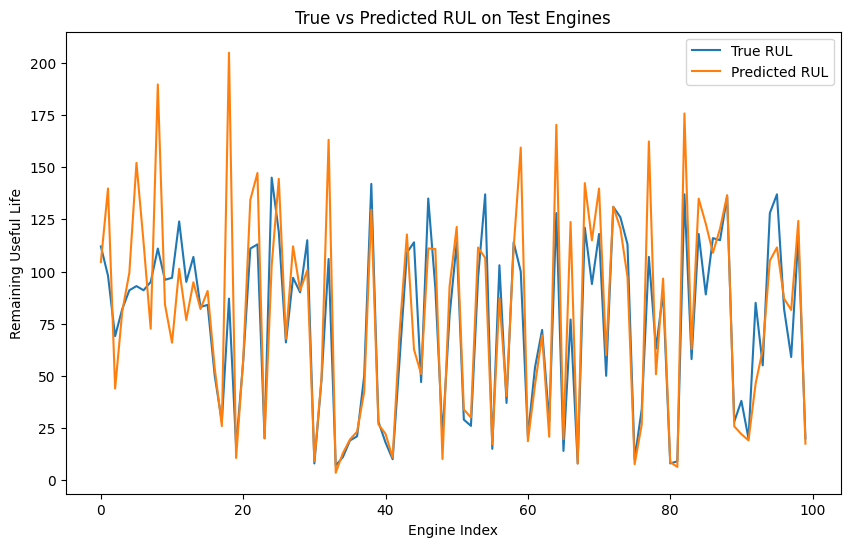

In [31]:
plt.figure(figsize=(10,6))
plt.plot(y_test, label='True RUL')
plt.plot(y_pred, label='Predicted RUL')
plt.xlabel('Engine Index')
plt.ylabel('Remaining Useful Life')
plt.title('True vs Predicted RUL on Test Engines')
plt.legend()
plt.show()


In [33]:
model.save("transformer_rul_model.h5")

In [34]:
from google.colab import files
files.download("transformer_rul_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Build Transformer Model  -handle Overfitting

In [56]:
def build_transformer_model(input_shape,head_size=45,num_heads=3,
                            ff_dim=128,num_blocks=2, conv_filters=64, dropout=0.3, lr=1e-4):
    inputs = layers.Input(shape=input_shape)
    x = layers.Dense(head_size)(inputs)

    
    seq_len = input_shape[0]
    pos_encoding = get_positional_encoding(seq_len, head_size)
    x = x + pos_encoding

    
    for _ in range(num_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(1)(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='mse')
    return model

In [59]:
input_shape = (X_train.shape[1], X_train.shape[2])
model = build_transformer_model(input_shape)

early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

model.fit(
    X_train, y_train,
    epochs=20, batch_size=128,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 43s 180ms/step - loss: 11933.3564
Epoch 2/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 41s 178ms/step - loss: 11090.5586
Epoch 3/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 41s 174ms/step - loss: 10058.0967
Epoch 4/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 42s 181ms/step - loss: 9204.7383
Epoch 5/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 39s 170ms/step - loss: 8071.3413
Epoch 6/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 25s 179ms/step - loss: 6984.8247
Epoch 7/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 25s 178ms/step - loss: 5866.6748
Epoch 8/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 42s 182ms/step - loss: 5119.9141
Epoch 9/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 40s 176ms/step - loss: 4497.3638
Epoch 10/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 25s 179ms/step - loss: 4092.1248
Epoch 11/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 24s 173ms/step - loss: 3937.4526
Epoch 12/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 24s 177ms/step - loss: 3818.7490
Epoch 13/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 24s 177ms/step - loss: 3799.8870
Epoch 14/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 25s

In [60]:
y_pred = model.predict(X_test).flatten()
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = 1 - (np.sum((y_test - y_pred) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2))

print(f"\nTest RMSE: {rmse:.2f}")
print(f"Test MAE: {mae:.2f}")
print(f"Test R²: {r2:.2f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 284ms/step

Test RMSE: 20.60
Test MAE: 16.28
Test R²: 0.75


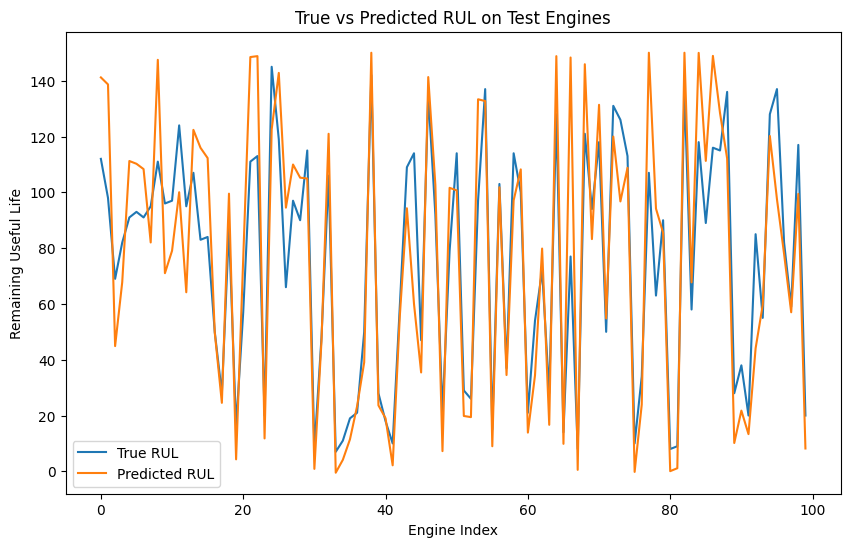

In [61]:
plt.figure(figsize=(10,6))
plt.plot(y_test, label='True RUL')
plt.plot(y_pred, label='Predicted RUL')
plt.xlabel('Engine Index')
plt.ylabel('Remaining Useful Life')
plt.title('True vs Predicted RUL on Test Engines')
plt.legend()
plt.show()

In [62]:
model.save("transformer2_rul_model.h5")